# Requirements

In [26]:
!pip install mne moabb braindecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import os.path as osp

import matplotlib.pyplot as plt
import mne
import seaborn as sns
import torch
import copy

from braindecode import EEGClassifier
from braindecode.datasets import create_from_X_y
from braindecode.models import ShallowFBCSPNet, EEGNetv4
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from braindecode.preprocessing import preprocess, Preprocessor

from moabb.datasets import BNCI2014001, PhysionetMI
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.utils import set_download_dir

import numpy as np
from numpy import unique, iscomplexobj, real, any, isfinite
from scipy.linalg import sqrtm, inv

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline


In [28]:
set_download_dir(osp.join(osp.expanduser("~"), "mne_data"))

# Euclidean Alignment as a transformation

In [ ]:
class EuclideanAlignment:
    """
    https://github.com/mcd4874/NeurIPS_competition/blob/4df1f222929e9824a55c9c4ae6634743391b0fe9/EEG_Lightning/dassl/data/datasets/data_util.py#L218
    convert trials of each subject to a new format with Euclidean Alignment technique
    https://arxiv.org/pdf/1808.05464.pdf
    """

    # Define Attributes
    def __init__(self, metadata, list_r_op=None,subject_ids=None):
      # list_r_op : list of each individual's reference matrix
        self.groups = metadata.subject.values
        self.runs = metadata.run.values
        self.list_r_op = list_r_op
        if subject_ids is not None:
            update_list_r_op = [self.list_r_op[subject_id] for subject_id in subject_ids]
            print("only use r-op for subjects {}".format(subject_ids))
            self.list_r_op = update_list_r_op

    # Calculate ref matrix
    def calculate_r_op(self,data):

        assert len(data.shape) == 3

        # compute mean covariance
        r = 0
        for trial in data:
            cov = np.cov(trial, rowvar=True)
            r += cov

        r = r/data.shape[0]

        if np.iscomplexobj(r):
            print("covariance matrix problem")
        if np.iscomplexobj(sqrtm(r)):
            print("covariance matrix problem sqrt")

        # compute ^-1/2
        r_op = inv(sqrtm(r))

        if np.iscomplexobj(r_op):
            print("WARNING! Covariance matrix was not SPD somehow. Can be caused by running ICA-EOG rejection, if "
                  "not, check data!!")
            r_op = np.real(r_op).astype(np.float64)
        elif not np.any(np.isfinite(r_op)):
            print("WARNING! Not finite values in R Matrix")
        return r_op

    # Matrix multiplication
    def convert_trials(self,data,r_op):
        results = np.matmul(r_op, data)
        return results

    # reference matrix for each subject
    def generate_list_r_op(self,subjects_data):
        list_r_op = list()
        for subject_idx in range(len(subjects_data)):
            subject_data = subjects_data[subject_idx]
            r_op = self.calculate_r_op(subject_data)
            list_r_op.append(r_op)
        return list_r_op

    # Apply the EA in all data
    def convert_all_data_with_EA(self,subjects_data):
        #calculate r_op for each subject (or run)
        
        if self.list_r_op is not None:
            assert len(self.list_r_op) == len(subjects_data)
            print("use exist r_op")

        else:
            print("generate new r_op")
            self.list_r_op = self.generate_list_r_op(subjects_data)

        new_data = list()

        for subject_idx in range(len(subjects_data)):

            subject_data = subjects_data[subject_idx]
            r_op = self.list_r_op[subject_idx]
            subject_data = self.convert_trials(subject_data,r_op)
            new_data.append(subject_data)

        return new_data

    # Apply the EA on subject_data
    def convert_subject_data_with_EA(self, subject_data):
        # calculate r_op for a subject (or run)
        r_op = self.calculate_r_op(subject_data)
        subject_data = self.convert_trials(subject_data,r_op)
        return subject_data, r_op

    # Apply the EA on a dataset on each run from all subjects
    def apply_EA(self, X, subjects_idx, n_runs):
      
      concat=[]; r_op_list=[]

      for subj in subjects_idx:
        print(f"Subject {subj}")
        X_subj, r_op = self.apply_EA_subj( X, subj, n_runs = n_runs )
        concat.append(X_subj)
        r_op_list.append(r_op)

      X_EA=np.concatenate(concat)

      return X_EA, r_op_list

    # Apply the EA on a subject
    def apply_EA_subj(self, X, subj, separate_runs = True, n_runs=None, run=None):

      data_subj = self.groups==subj

      #If we want to align each run
      if separate_runs == True:
        if run is None:
          concat=[]; r_op_list = []

          for k in range(n_runs):
            A = self.runs
            data_runs = A==f'run_{k}'
            intersec = np.logical_and(data_subj, data_runs)
            X_aux = copy.deepcopy(X[intersec])
            X_aux_EA, r_op = self.convert_subject_data_with_EA(X_aux)
            concat.append(X_aux_EA)

          X_EA = np.concatenate(concat)
          r_op_list.append(r_op)

        else:
          data_runs = self.runs==f'run_{run}'

          intersec = np.logical_and(data_subj, data_runs)
          X_aux = copy.deepcopy(X[intersec])
          X_EA, r_op_list = self.convert_subject_data_with_EA(X_aux)
      
      else:
        X_subj = X[data_subj]
        X_EA, r_op = self.convert_subject_data_with_EA(X_subj)

      return X_EA, r_op_list



In [ ]:
import numpy as np 
from scipy.linalg import sqrtm, inv
from numpy import iscomplexobj, real, any, isfinite
### Define this as Transformation, maybe...
def euclidean_alignment(data, y=None):

  data_EA=copy.deepcopy(data)

  assert len(data.shape) == 3

  print(len(data))

  r = 0
  for trial in data:
    cov = np.cov(trial, rowvar=True)
    r += cov

  r = r/len(data)

  if iscomplexobj(r):
    print("covariance matrix problem")
  if iscomplexobj(sqrtm(r)):
    print("covariance matrix problem sqrt")

  r_op = inv(sqrtm(r))

  if iscomplexobj(r_op):
    print("WARNING! Covariance matrix was not SPD somehow. "+
            "Can be caused by running ICA-EOG rejection, if "+
            "not, check data!!")
    r_op = real(r_op).astype(np.float64)
  elif not any(isfinite(r_op)):
    print("WARNING! Not finite values in R Matrix")

  result = np.matmul(r_op, data)

  return result


# dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])


In [ ]:
def split_runs_EA(X,rpc, n_classes):
  X_aux = []
  m = rpc*n_classes
  n = X.shape[0]
  for k in range(int(n/m)):
    run = X[k*m:(k+1)*m]
    run_EA = euclidean_alignment(run)
    X_aux.append(run_EA)
  X_EA = np.concatenate(X_aux)
  return X_EA
  

The Cross-Subject Evaluation divides the test individual's sessions? How to use both?

In [ ]:
i=0
A = runs==f'run_{i}'
B = groups==1
C = np.logical_and(A,B)
B

array([ True,  True,  True, ..., False, False, False])

In [ ]:
groups = metadata.subject.values
sessions = metadata.session.values
runs = metadata.run.values
subjects_idx =dataset_a.subject_list
n_runs = 6
EA = EuclideanAlignment(metadata)
X_EA,_ = EA.apply_EA(X, subjects_idx, n_runs)

Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9


In [ ]:
X_EA

In [ ]:
X

# Load datasets

In [29]:
# Define Evaluation
paradigm = LeftRightImagery()
# Because this is being auto-generated we only use 2 subjects
dataset_a = BNCI2014001()
dataset_b = PhysionetMI(imagined=True)

#dataset.subject_list = dataset.subject_list[:9]
# Por que criamos essa lista datasets? 
# Fazendo isso os modelos vao ser criados entre os proprios datasets ou vai misturar?
datasets = [dataset_a]

To obtain the number of channels and input windows samples, can we hard-code with the right paramethers (that are known) or do we need to extract them?

In [ ]:
X, y, metadata = paradigm.get_data(dataset_a)

In [ ]:
X.shape

(2592, 22, 1001)

In [ ]:
groups = metadata.subject.values
sessions = metadata.session.values
n_subjects = len(dataset_a.subject_list)


In [ ]:
groups.shape

(2592,)

In [ ]:
np.unique(groups)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm

loo = LeaveOneGroupOut()
for test, train in tqdm(
                loo.split(X, y, groups),
                total=n_subjects,
                desc=f"{dataset_a.code}-WithinSubject"):

  print(test.shape)
  ix = groups[test] == 1
  print(X[test[ix]].shape)
  print(X[train].shape)

In [ ]:
X[:24].shape

(24, 22, 1001)

In [ ]:
X_EA = split_runs_EA(X, 12, 2)

In [ ]:
X.shape

(2592, 22, 1001)

In [ ]:
2592/9

288.0

In [ ]:
(2592/9)/2

144.0

In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(metadata)

pandas.core.frame.DataFrame

# Create model and classifier

Some doubts: thw 2 datasets we'rw using have different number of channels and classes. How do we define the number of channels we're going to use?? How to select the channels?

* Tem como definir uma sequência? Tipo, primeiro cria e avalia p/ BBNCI201400 e depois p Physionet?

In [ ]:
def set_det_device():
  cuda = (
      torch.cuda.is_available()
  )  # check if GPU is available, if True chooses to use it
  device = "cuda" if cuda else "cpu"
  if cuda:
      torch.backends.cudnn.benchmark = True
  seed = 20200220  # random seed to make results reproducible
  # Set random seed to be able to reproduce results
  set_random_seeds(seed=seed, cuda=cuda)
  return device

In [30]:
cuda = (
    torch.cuda.is_available()
)  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2

# hard-coded for now
# How to adjust??
# PARAMETHERS FOR THE BBNCI2014001 DATASET
n_chans = 22
input_window_samples = 1001

'''
# PARAMETHERS FOR THE PHYSIONET DATASET
n_chans = 64
input_window_samples = 481
'''

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    drop_prob=0.5
)


# Send model to GPU
if cuda:
    model.cuda()

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 100

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
)

/usr/local/lib/python3.8/dist-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Idea: (since some parameters are different for different datasets)

In [ ]:
def init_model( n_chans, n_classes, input_window_samples):
  model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    drop_prob=0.5
  )
  return model

# Define pipeline

Why is it important? Define sequence of transformations

Can we use the make_pipeline func?

In [31]:
class TransformaParaWindowsDataset(BaseEstimator, TransformerMixin):
    def __init__(self, kw_args=None):
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        # self.X = euclidean_alignment(X.get_data())
        return self

    def transform(self, X, y=None ):
        '''
        metadata = X.metadata
        X_aux = X.get_data()    

        subjects_idx = list(range(1,10))
        n_runs = 6
        EA = EuclideanAlignment(metadata)
        X_EA,_ = EA.apply_EA( X_aux, subjects_idx, n_runs)
        '''

        #X_EA = split_runs_EA(X.get_data(), 12, 2)

        dataset = create_from_X_y(
            #X=X_EA,
            X=X.get_data(),
            y=self.y,
            window_size_samples=X.get_data().shape[2],
            window_stride_samples=X.get_data().shape[2],
            drop_last_window=False,
            sfreq=X.info["sfreq"],
        )

        # dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transfomer is stateless."""
        return True


class TransformaParaWindowsDatasetEA(BaseEstimator, TransformerMixin):
    def __init__(self, kw_args=None):
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.y = y
        # self.X = euclidean_alignment(X.get_data())
        return self

    def transform(self, X, y=None ):

        X_EA = split_runs_EA(X.get_data(), 12, 2)

        dataset = create_from_X_y(
            X=X_EA,
            y=self.y,
            window_size_samples=X.get_data().shape[2],
            window_stride_samples=X.get_data().shape[2],
            drop_last_window=False,
            sfreq=X.info["sfreq"],
        )

        # dataset_EA = preprocess(dataset,[Preprocessor(euclidean_alignment,apply_on_array=True)])

        return dataset

    def __sklearn_is_fitted__(self):
        """Return True since Transfomer is stateless."""
        return True



In [32]:
class ClassifierModel(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, kw_args=None):
        self.clf = clf
        self.classes_ = None
        self.kw_args = kw_args

    def fit(self, X, y=None):
        self.clf.fit(X, y=y, **self.kw_args)
        self.classes_ = unique(y)

        return self.clf

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



In [33]:
# if euclidean alignment:
# create_dataset = TransformaParaWindowsDatasetEA()
create_dataset = TransformaParaWindowsDataset()

fit_params = {"epochs": 100}

brain_clf = ClassifierModel(clf, fit_params)

pipe = Pipeline([("Braindecode_dataset", create_dataset), 
                 ("Net", brain_clf)])
print(pipe)
pipes = {}
pipes["EEGNetv4"] = pipe

Pipeline(steps=[('Braindecode_dataset', TransformaParaWindowsDataset()),
                ('Net',
                 ClassifierModel(clf=<class 'braindecode.classifier.EEGClassifier'>[uninitialized](
  module=EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=_transpose_to_b_1_c_0) 
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_tem...
    (elu_2): Expression(expression=elu) 
    (pool_2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(16, 2, kernel_size=(1, 31), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (permute_back): Expression(expression=_transpose_1_0) 
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
),
                                 kw_args={'epochs': 100}))])


# **Some tests with paradigm methods**

How can I use this to separate X_trains?

In [ ]:
a=np.array([1,2])
b=np.array([3,4])
c=np.concatenate([a,b])
c

array([1, 2, 3, 4])

In [ ]:
paradigm = LeftRightImagery()
# Because this is being auto-generated we only use 2 subjects
dataset = BNCI2014001()
dataset_b = PhysionetMI(imagined=True)

In [ ]:
X.shape

(2592, 22, 1001)

In [ ]:
X, y, metadata = paradigm.get_data(dataset_a)

/usr/local/lib/python3.8/dist-packages/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 29.8GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 24.1GB/s]
SHA256 hash of downloaded file: 53d415f39c3d7b0c88b894d7b08d99bcdfe855ede63831d3691af1a45607fb62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.1M/43.1M [00:00<00:00, 30.2GB/s]
SHA256 hash of downloaded file: 5ddd5cb520b1692c3ba1363f48d98f58f0e46f3699ee50d749947950fc39db27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

In [ ]:
dataset_b.subject_list=subj = list(range(1,4))

In [ ]:
Xb, yb, metadatab = paradigm.get_data(dataset_b)

100%|█████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 1.85GB/s]
SHA256 hash of downloaded file: 7d0732eea963488a53153835524e55c2b68220b0a0c7c5be99e535a9f5367e7f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 2.05GB/s]
SHA256 hash of downloaded file: 0f50978bb972e693b8c758a9223a2d9fa35c7f117226391090bcc32a83ce765d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|██████████████████████████████████████| 2.60M/2.60M [00:00<00:00, 995MB/s]
SHA256 hash of downloaded file: bbf7137bfa7905724741e95359fa090439d4422c07bdba16c792acb09ebd6421
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

In [ ]:
Xb.shape

(135, 64, 481)

(90, 64, 481)

In [ ]:
dataset

X.shape = (a,b,c)

a : epochs (number of trials)

b : channels 

c : time sample 

If the number of channels and time samples of each dataset are different, how can I define the model? 

In [ ]:
X.shape

In [ ]:
X_b.shape

In [ ]:
metadata

,subject,session,run
0,1,session_T,run_0
1,1,session_T,run_0
2,1,session_T,run_0
3,1,session_T,run_0
4,1,session_T,run_0
...,...,...,...
2587,9,session_E,run_5
2588,9,session_E,run_5
2589,9,session_E,run_5
2590,9,session_E,run_5


In [ ]:
groups = metadata.subject.values
sessions = metadata.session.values
runs = metadata.run.values
n_subjects = len(dataset_a.subject_list)

In [ ]:
import copy

def X_subj(X,subj,run=None):
  data_subj = groups==subj

  if run is None:
    for k in range(6):
      data_runs = runs==f'run_{k}'

      intersec = np.logical_and(data_subj, data_runs)
      X_aux = copy.deepcopy(X[intersec])

  else:
    data_runs = runs==f'run_{run}'

    intersec = np.logical_and(data_subj, data_runs)
    X_aux = copy.deepcopy(X[intersec])

  return X_aux
X_subj_0 = X_subj(X,1,0)
X_subj_1 = X_subj(X,1,1)

In [ ]:
X_a = np.concatenate([X_subj_0, X_subj_1])

In [ ]:
X_a.shape

(96, 22, 1001)

In [ ]:
X_subj

In [ ]:
EA = EuclideanAlignment()
X_EA = EA.convert_subject_data_with_EA(X_subj)
X_EA

In [ ]:
groups

array([1, 1, 1, ..., 9, 9, 9])

In [ ]:
sessions

array(['session_T', 'session_T', 'session_T', ..., 'session_E',
       'session_E', 'session_E'], dtype=object)

In [ ]:
runs

array(['run_0', 'run_0', 'run_0', ..., 'run_5', 'run_5', 'run_5'],
      dtype=object)

In [ ]:
A=runs=='run_0'

In [ ]:
B=groups==1

In [ ]:
len(B)

2592

In [ ]:
len(A)

2592

In [ ]:
C=np.logical_and(A,B)
len(C)

2592

In [ ]:
X[groups==1]

array(['run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0', 'run_0',
       'run_0', 'run_0', 'run_0'], dtype=object)

In [ ]:
X[metadata.subject.values==1]

array([[[  6.12675343,   4.80069492,   1.8937593 , ...,  -1.80963356,
          -0.95822005,   0.10018214],
        [  5.58056783,   3.78074325,   1.02786715, ...,  -1.32946883,
          -0.62293255,   0.06768451],
        [  7.43279059,   5.46171881,   2.11057866, ...,  -0.57576039,
          -0.65376666,  -0.73565678],
        ...,
        [  7.465582  ,   3.39468294,  -1.15504664, ...,  -3.41820391,
          -2.94795975,  -2.31999583],
        [  5.00811146,   1.58727604,  -2.11582106, ...,  -3.48512891,
          -2.69524861,  -1.68924441],
        [  8.01582351,   4.2274779 ,  -0.1410632 , ...,  -4.097163  ,
          -3.54158428,  -2.65380789]],

       [[ -0.7702083 ,  -0.77995427,  -1.51378905, ...,  -9.44448146,
         -11.03344346, -11.02605606],
        [ -1.33536169,  -1.04522174,  -0.87003607, ...,  -8.77443588,
         -10.72309939, -10.2110244 ],
        [  0.30316772,   0.02742408,  -1.01425588, ...,  -9.24718849,
         -11.26148117, -10.91802947],
        ...,


# Evaluation


In [34]:
import logging
from copy import deepcopy
from time import time
from typing import Optional, Union

import numpy as np
from mne.epochs import BaseEpochs
from sklearn.base import clone
from sklearn.metrics import get_scorer
from sklearn.model_selection import (
    LeaveOneOut,
    LeaveOneGroupOut,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
)
from sklearn.model_selection._validation import _fit_and_score, _score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from moabb.evaluations.base import BaseEvaluation

log = logging.getLogger(__name__)

# Numpy ArrayLike is only available starting from Numpy 1.20 and Python 3.8
Vector = Union[list, tuple, np.ndarray]

In [ ]:
class CrossCrossSubjectEvaluation(BaseEvaluation):
    """
    Temporary name! 
    I want to create the evaluation that I did in the experiment 4. For this, I created one
    classifier per subject, and evaluated using the other ones.

    Parameters
    ----------
    paradigm : Paradigm instance
        The paradigm to use.
    datasets : List of Dataset instance
        The list of dataset to run the evaluation. If none, the list of
        compatible dataset will be retrieved from the paradigm instance.
    random_state: int, RandomState instance, default=None
        If not None, can guarantee same seed for shuffling examples.
    n_jobs: int, default=1
        Number of jobs for fitting of pipeline.
    overwrite: bool, default=False
        If true, overwrite the results.
    error_score: "raise" or numeric, default="raise"
        Value to assign to the score if an error occurs in estimator fitting. If set to
        'raise', the error is raised.
    suffix: str
        Suffix for the results file.
    hdf5_path: str
        Specific path for storing the results.
    additional_columns: None
        Adding information to results.
    return_epochs: bool, default=False
        use MNE epoch to train pipelines.
    mne_labels: bool, default=False
        if returning MNE epoch, use original dataset label if True
    """

    def evaluate(self, dataset, pipelines):
        if not self.is_valid(dataset):
            raise AssertionError("Dataset is not appropriate for evaluation")
        # this is a bit akward, but we need to check if at least one pipe
        # have to be run before loading the data. If at least one pipeline
        # need to be run, we have to load all the data.
        # we might need a better granularity, if we query the DB
        run_pipes = {}
        for subject in dataset.subject_list:
            run_pipes.update(self.results.not_yet_computed(pipelines, dataset, subject))
        if len(run_pipes) != 0:

            # get the data
            X, y, metadata = self.paradigm.get_data(dataset,
                                                    return_epochs=self.return_epochs)

            # encode labels
            le = LabelEncoder()
            y = y if self.mne_labels else le.fit_transform(y)

            # extract metadata
            groups = metadata.subject.values
            sessions = metadata.session.values
            n_subjects = len(dataset.subject_list)

            scorer = get_scorer(self.paradigm.scoring)

            # perform leave one subject out CV
            cv = LeaveOneGroupOut()
            # Progressbar at subject level
            for test, train in tqdm(
                cv.split(X, y, groups),
                total=n_subjects,
                desc=f"{dataset.code}-CrossCrossSubject"):

                #aux = np.unique(groups[test])
                #subj_0 = aux[0]
                run_pipes = self.results.not_yet_computed(pipelines, dataset, groups[train[0]])

                for name, clf in run_pipes.items():
                    t_start = time()
                    model = deepcopy(clf).fit(X[train], y[train])
                    duration = time() - t_start

                    # for each test subject
                    for subject in np.unique(groups[test]):
                        # Now evaluate
                        ix = groups[test] == subject
                        score = _score(model, X[test[ix]], y[test[ix]], scorer)
                        session = 'both'
                        nchan = (
                            X.info["nchan"] if isinstance(X, BaseEpochs) else X.shape[1]
                        )
                        res = {
                            "time": duration,
                            "dataset": dataset,
                            "subject": subject,
                            "session": session,
                            "score": score,
                            "n_samples": len(train),
                            "n_channels": nchan,
                            "pipeline": name,
                        }

                        yield res

    def is_valid(self, dataset):
        return len(dataset.subject_list) > 1

In [35]:
class CrossCrossSubjectEvaluation3(BaseEvaluation):
    """
    Temporary name! 
    I want to create the evaluation that I did in the experiment 4. For this, I created one
    classifier per subject, and evaluated using the other ones.

    Parameters
    ----------
    paradigm : Paradigm instance
        The paradigm to use.
    datasets : List of Dataset instance
        The list of dataset to run the evaluation. If none, the list of
        compatible dataset will be retrieved from the paradigm instance.
    random_state: int, RandomState instance, default=None
        If not None, can guarantee same seed for shuffling examples.
    n_jobs: int, default=1
        Number of jobs for fitting of pipeline.
    overwrite: bool, default=False
        If true, overwrite the results.
    error_score: "raise" or numeric, default="raise"
        Value to assign to the score if an error occurs in estimator fitting. If set to
        'raise', the error is raised.
    suffix: str
        Suffix for the results file.
    hdf5_path: str
        Specific path for storing the results.
    additional_columns: None
        Adding information to results.
    return_epochs: bool, default=False
        use MNE epoch to train pipelines.
    mne_labels: bool, default=False
        if returning MNE epoch, use original dataset label if True
    """

    def evaluate(self, dataset, pipelines):
        if not self.is_valid(dataset):
            raise AssertionError("Dataset is not appropriate for evaluation")
        # this is a bit akward, but we need to check if at least one pipe
        # have to be run before loading the data. If at least one pipeline
        # need to be run, we have to load all the data.
        # we might need a better granularity, if we query the DB
        run_pipes = {}
        for subject in dataset.subject_list:
            run_pipes.update(self.results.not_yet_computed(pipelines, dataset, subject))
        if len(run_pipes) != 0:

            # get the data
            X, y, metadata = self.paradigm.get_data(dataset,
                                                    return_epochs=self.return_epochs)

            # encode labels
            le = LabelEncoder()
            y = y if self.mne_labels else le.fit_transform(y)

            # extract metadata
            groups = metadata.subject.values
            sessions = metadata.session.values
            n_subjects = len(dataset.subject_list)

            scorer = get_scorer(self.paradigm.scoring)

            # perform leave one subject out CV
            cv = LeaveOneGroupOut()
            # Progressbar at subject level
            model_list=[]
            for test, train in tqdm(
                cv.split(X, y, groups),
                total=n_subjects,
                desc=f"{dataset.code}-CrossCrossSubject"):

                #aux = np.unique(groups[test])
                #subj_0 = aux[0]
                run_pipes = self.results.not_yet_computed(pipelines, dataset, groups[train[0]])
                
                for name, clf in run_pipes.items():
                    t_start = time()
                    model = deepcopy(clf).fit(X[train], y[train])
                    duration = time() - t_start
                    model_list.append(model)
                    
                    # for each test subject
                    for subject in np.unique(groups[test]):
                        # Now evaluate
                        ix = groups[test] == subject
                        score = _score(model, X[test[ix]], y[test[ix]], scorer)
                        session = 'both'
                        nchan = (
                            X.info["nchan"] if isinstance(X, BaseEpochs) else X.shape[1]
                        )
                        res = {
                            "time": duration,
                            "dataset": dataset,
                            "subject": groups[train[0]],
                            "test": subject,
                            "session": session,
                            "score": score,
                            "n_samples": len(train),
                            "n_channels": nchan,
                            "pipeline": name,
                        }

                        yield res

    def is_valid(self, dataset):
        return len(dataset.subject_list) > 1

# Train

Using LOO cross-validation

In [44]:
def add_test_column(dataset,results):
  subj_list = dataset.subject_list
  list_=[]
  for i in subj_list:
    subj_copy = copy.deepcopy(subj_list)
    subj_copy.remove(i)
    list_.append(subj_copy)

  array=np.array(list_)
  test=array.flatten()
  results.insert(4,'test',test,True)
  return results

array([2, 3, 4, 5, 6, 7, 8, 9, 1, 3, 4, 5, 6, 7, 8, 9, 1, 2, 4, 5, 6, 7,
       8, 9, 1, 2, 3, 5, 6, 7, 8, 9, 1, 2, 3, 4, 6, 7, 8, 9, 1, 2, 3, 4,
       5, 7, 8, 9, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 9, 1, 2,
       3, 4, 5, 6, 7, 8])

In [25]:
mne.set_log_level(False)

overwrite = True  # set to True if we want to overwrite cached results
evaluation = CrossCrossSubjectEvaluation3(
    paradigm=paradigm,
    datasets=datasets,
    suffix="braindecode_example",
    overwrite=overwrite,
    return_epochs=True,
)

results = evaluation.process(pipes)
#results = add_test_column(datasets[0],results)
print(results.head())


001-2014-CrossCrossSubject:   0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6932  0.0006  0.2660
      2            0.5000        0.6931  0.0006  0.2645
      3            0.5000        0.6947  0.0006  0.2561
      4            0.5000        0.6946  0.0006  0.2570
      5            0.5000        0.6927  0.0006  0.2605
      6            0.5000        0.6926  0.0006  0.2665
      7            0.5000        0.6928  0.0006  0.2609
      8            0.5000        0.6926  0.0006  0.2550
      9            0.5000        0.6915  0.0006  0.2650
     10            0.5000        0.6911  0.0006  0.2640
     11            0.5000        0.6921  0.0006  0.2708
     12            0.5000        0.6929  0.0006  0.2621
     13            0.5000        0.6913  0.0006  0.2640
     14            0.5000        0.6929  0.0006  0.2641
     15            0.5000        0.6962  0.0006  0.2636
     16            0.5000        0.6913  0.0006 

001-2014-CrossCrossSubject:  11%|█         | 1/9 [01:06<08:50, 66.34s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6935  0.0006  0.2653
      2            0.5000        0.6943  0.0006  0.2645
      3            0.5000        0.6937  0.0006  0.2659
      4            0.5000        0.6929  0.0006  0.2627
      5            0.5000        0.6930  0.0006  0.2590
      6            0.5000        0.6923  0.0006  0.2764
      7            0.5000        0.6928  0.0006  0.2595
      8            0.5000        0.6935  0.0006  0.2773
      9            0.5000        0.6942  0.0006  0.2892
     10            0.5000        0.6937  0.0006  0.2668
     11            0.5000        0.6935  0.0006  0.2701
     12            0.5000        0.6945  0.0006  0.2562
     13            0.5000        0.6939  0.0006  0.2605
     14            0.5000        0.6917  0.0006  0.2661
     15            0.5000        0.6936  0.0006  0.2637
     16            0.5000        0.6918  0.0006 

001-2014-CrossCrossSubject:  22%|██▏       | 2/9 [02:12<07:42, 66.13s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6932  0.0006  0.2711
      2            0.5000        0.6932  0.0006  0.2681
      3            0.5000        0.6939  0.0006  0.2571
      4            0.5000        0.6949  0.0006  0.2665
      5            0.5000        0.6939  0.0006  0.2587
      6            0.5000        0.6929  0.0006  0.2616
      7            0.5000        0.6933  0.0006  0.2634
      8            0.5000        0.6932  0.0006  0.2676
      9            0.5000        0.6945  0.0006  0.2567
     10            0.5000        0.6929  0.0006  0.2630
     11            0.5000        0.6928  0.0006  0.2625
     12            0.5000        0.6931  0.0006  0.2634
     13            0.5000        0.6923  0.0006  0.2673
     14            0.5000        0.6920  0.0006  0.2738
     15            0.5000        0.6914  0.0006  0.2663
     16            0.5000        0.6945  0.0006 

001-2014-CrossCrossSubject:  33%|███▎      | 3/9 [03:17<06:35, 65.89s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6936  0.0006  0.2659
      2            0.5000        0.6932  0.0006  0.2647
      3            0.5000        0.6934  0.0006  0.2617
      4            0.5000        0.6940  0.0006  0.2735
      5            0.5000        0.6924  0.0006  0.2604
      6            0.5000        0.6922  0.0006  0.2712
      7            0.5000        0.6927  0.0006  0.2640
      8            0.5000        0.6916  0.0006  0.2540
      9            0.5000        0.6936  0.0006  0.2540
     10            0.5000        0.6939  0.0006  0.2486
     11            0.5000        0.6931  0.0006  0.2470
     12            0.5000        0.6928  0.0006  0.2435
     13            0.5000        0.6920  0.0006  0.2367
     14            0.5000        0.6939  0.0006  0.2428
     15            0.5000        0.6961  0.0006  0.2441
     16            0.5000        0.6922  0.0006 

001-2014-CrossCrossSubject:  44%|████▍     | 4/9 [04:22<05:26, 65.33s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6933  0.0006  0.2619
      2            0.5000        0.6921  0.0006  0.2598
      3            0.5000        0.6945  0.0006  0.2577
      4            0.5000        0.6943  0.0006  0.2505
      5            0.5000        0.6934  0.0006  0.2573
      6            0.5000        0.6932  0.0006  0.2572
      7            0.5000        0.6929  0.0006  0.2594
      8            0.5000        0.6934  0.0006  0.2692
      9            0.5000        0.6929  0.0006  0.2532
     10            0.5000        0.6928  0.0006  0.2511
     11            0.5000        0.6950  0.0006  0.2496
     12            0.5000        0.6930  0.0006  0.2533
     13            0.5000        0.6928  0.0006  0.2576
     14            0.5000        0.6937  0.0006  0.2744
     15            0.5000        0.6915  0.0006  0.2812
     16            0.5000        0.6955  0.0006 

001-2014-CrossCrossSubject:  56%|█████▌    | 5/9 [05:26<04:20, 65.00s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6931  0.0006  0.2661
      2            0.5000        0.6926  0.0006  0.2622
      3            0.5000        0.6924  0.0006  0.2659
      4            0.5000        0.6922  0.0006  0.2699
      5            0.5000        0.6935  0.0006  0.2625
      6            0.5000        0.6911  0.0006  0.2664
      7            0.5000        0.6949  0.0006  0.2597
      8            0.5000        0.6919  0.0006  0.2620
      9            0.5000        0.6921  0.0006  0.2636
     10            0.5000        0.6944  0.0006  0.2660
     11            0.5000        0.6930  0.0006  0.2651
     12            0.5000        0.6926  0.0006  0.2661
     13            0.5000        0.6935  0.0006  0.2605
     14            0.5000        0.6918  0.0006  0.2618
     15            0.5000        0.6950  0.0006  0.2633
     16            0.5000        0.6952  0.0006 

001-2014-CrossCrossSubject:  67%|██████▋   | 6/9 [06:31<03:15, 65.05s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6934  0.0006  0.2651
      2            0.5000        0.6931  0.0006  0.2794
      3            0.5000        0.6934  0.0006  0.2686
      4            0.5000        0.6932  0.0006  0.2682
      5            0.5000        0.6936  0.0006  0.2569
      6            0.5000        0.6930  0.0006  0.2573
      7            0.5000        0.6920  0.0006  0.2688
      8            0.5000        0.6940  0.0006  0.2722
      9            0.5000        0.6938  0.0006  0.2719
     10            0.5000        0.6904  0.0006  0.2544
     11            0.5000        0.6952  0.0006  0.2480
     12            0.5000        0.6900  0.0006  0.2490
     13            0.5000        0.6934  0.0006  0.2475
     14            0.5000        0.6932  0.0006  0.2461
     15            0.5000        0.6960  0.0006  0.2456
     16            0.5000        0.6946  0.0006 

001-2014-CrossCrossSubject:  78%|███████▊  | 7/9 [07:37<02:10, 65.06s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6927  0.0006  0.2679
      2            0.5000        0.6926  0.0006  0.2587
      3            0.5000        0.6942  0.0006  0.2586
      4            0.5000        0.6928  0.0006  0.2598
      5            0.5000        0.6929  0.0006  0.2492
      6            0.5000        0.6917  0.0006  0.2471
      7            0.5000        0.6948  0.0006  0.2507
      8            0.5000        0.6935  0.0006  0.2513
      9            0.5000        0.6921  0.0006  0.2526
     10            0.5000        0.6931  0.0006  0.2586
     11            0.5000        0.6928  0.0006  0.2651
     12            0.5000        0.6947  0.0006  0.2515
     13            0.5000        0.6924  0.0006  0.2591
     14            0.5000        0.6923  0.0006  0.2659
     15            0.5000        0.6905  0.0006  0.2563
     16            0.5000        0.6922  0.0006 

001-2014-CrossCrossSubject:  89%|████████▉ | 8/9 [08:41<01:05, 65.02s/it]

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5000        0.6922  0.0006  0.2672
      2            0.5000        0.6938  0.0006  0.2639
      3            0.5000        0.6921  0.0006  0.2613
      4            0.5000        0.6926  0.0006  0.2509
      5            0.5000        0.6914  0.0006  0.2569
      6            0.5000        0.6913  0.0006  0.2505
      7            0.5000        0.6940  0.0006  0.2560
      8            0.5000        0.6925  0.0006  0.2578
      9            0.5000        0.6945  0.0006  0.2637
     10            0.5000        0.6916  0.0006  0.2634
     11            0.5000        0.6925  0.0006  0.2569
     12            0.5000        0.6910  0.0006  0.2587
     13            0.5000        0.6959  0.0006  0.2627
     14            0.5000        0.6929  0.0006  0.2672
     15            0.5000        0.6952  0.0006  0.2606
     16            0.5000        0.6902  0.0006 

001-2014-CrossCrossSubject: 100%|██████████| 9/9 [09:46<00:00, 65.20s/it]

      score       time  samples subject session  channels  n_sessions  \
0  0.452643  50.132069    288.0       1    both        22           2   
1  0.466556  50.132069    288.0       1    both        22           2   
2  0.496648  50.132069    288.0       1    both        22           2   
3  0.509163  50.132069    288.0       1    both        22           2   
4  0.538604  50.132069    288.0       1    both        22           2   

    dataset  pipeline  
0  001-2014  EEGNetv4  
1  001-2014  EEGNetv4  
2  001-2014  EEGNetv4  
3  001-2014  EEGNetv4  
4  001-2014  EEGNetv4  


In [47]:
results

,score,time,samples,subject,test,session,channels,n_sessions,dataset,pipeline
0,0.452643,50.132069,288.0,1,2,both,22,2,001-2014,EEGNetv4
1,0.466556,50.132069,288.0,1,3,both,22,2,001-2014,EEGNetv4
2,0.496648,50.132069,288.0,1,4,both,22,2,001-2014,EEGNetv4
3,0.509163,50.132069,288.0,1,5,both,22,2,001-2014,EEGNetv4
4,0.538604,50.132069,288.0,1,6,both,22,2,001-2014,EEGNetv4
...,...,...,...,...,...,...,...,...,...,...
67,0.493152,48.950687,288.0,9,4,both,22,2,001-2014,EEGNetv4
68,0.438368,48.950687,288.0,9,5,both,22,2,001-2014,EEGNetv4
69,0.588445,48.950687,288.0,9,6,both,22,2,001-2014,EEGNetv4
70,0.531202,48.950687,288.0,9,7,both,22,2,001-2014,EEGNetv4


# Visualize

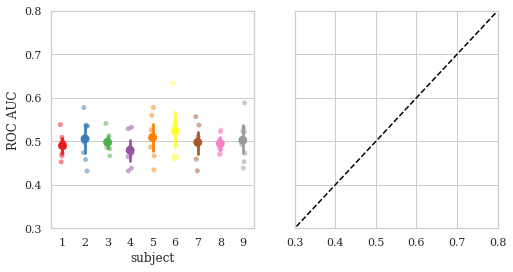

In [54]:

##############################################################################
# Plot Results
# ----------------
#
# Here we plot the results. We the first plot is a pointplot with the average
# performance of each pipeline across session and subjects.
# The second plot is a paired scatter plot. Each point representing the score
# of a single session. An algorithm will outperforms another is most of the
# points are in its quadrant.

fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="subject",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(
    data=results, y="score", x="subject", ax=axes[0], zorder=1, palette="Set1"
)

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.3, 0.8)

# paired plot
paired = results.pivot_table(
    values="score", columns="pipeline", index=["subject", "session"]
)
paired = paired.reset_index()

axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.3, 0.8)

plt.show()